In [89]:
# Importing all of the libraries we need
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from scipy import sparse

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelofarrell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
# Importing the dataset into relevant matrices and vectors
dataset = pd.read_csv('IMDb movies dataset.csv')
dataset.head()

/Users/michaelofarrell/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,reviews_from_users,reviews_from_critics
0,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,1.0,2.0
1,The Story of the Kelly Gang,1906,12/26/1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,"$2,250",7.0,7.0
2,Den sorte drøm,1911,8/19/1911,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,5.0,2.0
3,Cleopatra,1912,11/13/1912,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,"$45,000",25.0,3.0
4,L'Inferno,1911,3/6/1911,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,31.0,14.0


In [91]:
# Getting some basic info about the dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 85855 non-null  object 
 1   year                  85855 non-null  object 
 2   date_published        85855 non-null  object 
 3   genre                 85855 non-null  object 
 4   duration              85855 non-null  int64  
 5   country               85791 non-null  object 
 6   language              85022 non-null  object 
 7   director              85768 non-null  object 
 8   writer                84283 non-null  object 
 9   production_company    81400 non-null  object 
 10  actors                85786 non-null  object 
 11  description           83740 non-null  object 
 12  avg_vote              85855 non-null  float64
 13  votes                 85855 non-null  int64  
 14  budget                23710 non-null  object 
 15  reviews_from_users 

In [92]:
# we're only going to look at movies that have USA listed as a country
# we're also going to describe the numerical aspects of the dataset
dataset['country'].fillna('', inplace = True)
dataset = dataset[dataset['country'].str.contains('USA')]
num_data = ['duration', 'avg_vote', 'votes', 'reviews_from_users', 'reviews_from_critics']
dataset[num_data].describe()

,duration,avg_vote,votes,reviews_from_users,reviews_from_critics
count,34325.000000,34325.000000,3.432500e+04,33931.000000,32250.000000
mean,94.605273,5.609413,1.999168e+04,82.781203,41.832031
std,18.796947,1.273202,8.161522e+04,252.584710,78.525503
min,42.000000,1.100000,9.900000e+01,1.000000,1.000000
25%,85.000000,4.800000,2.520000e+02,8.000000,4.000000
50%,92.000000,5.800000,7.380000e+02,19.000000,12.000000
75%,102.000000,6.500000,4.561000e+03,54.000000,39.000000
max,398.000000,9.700000,2.278845e+06,10472.000000,999.000000


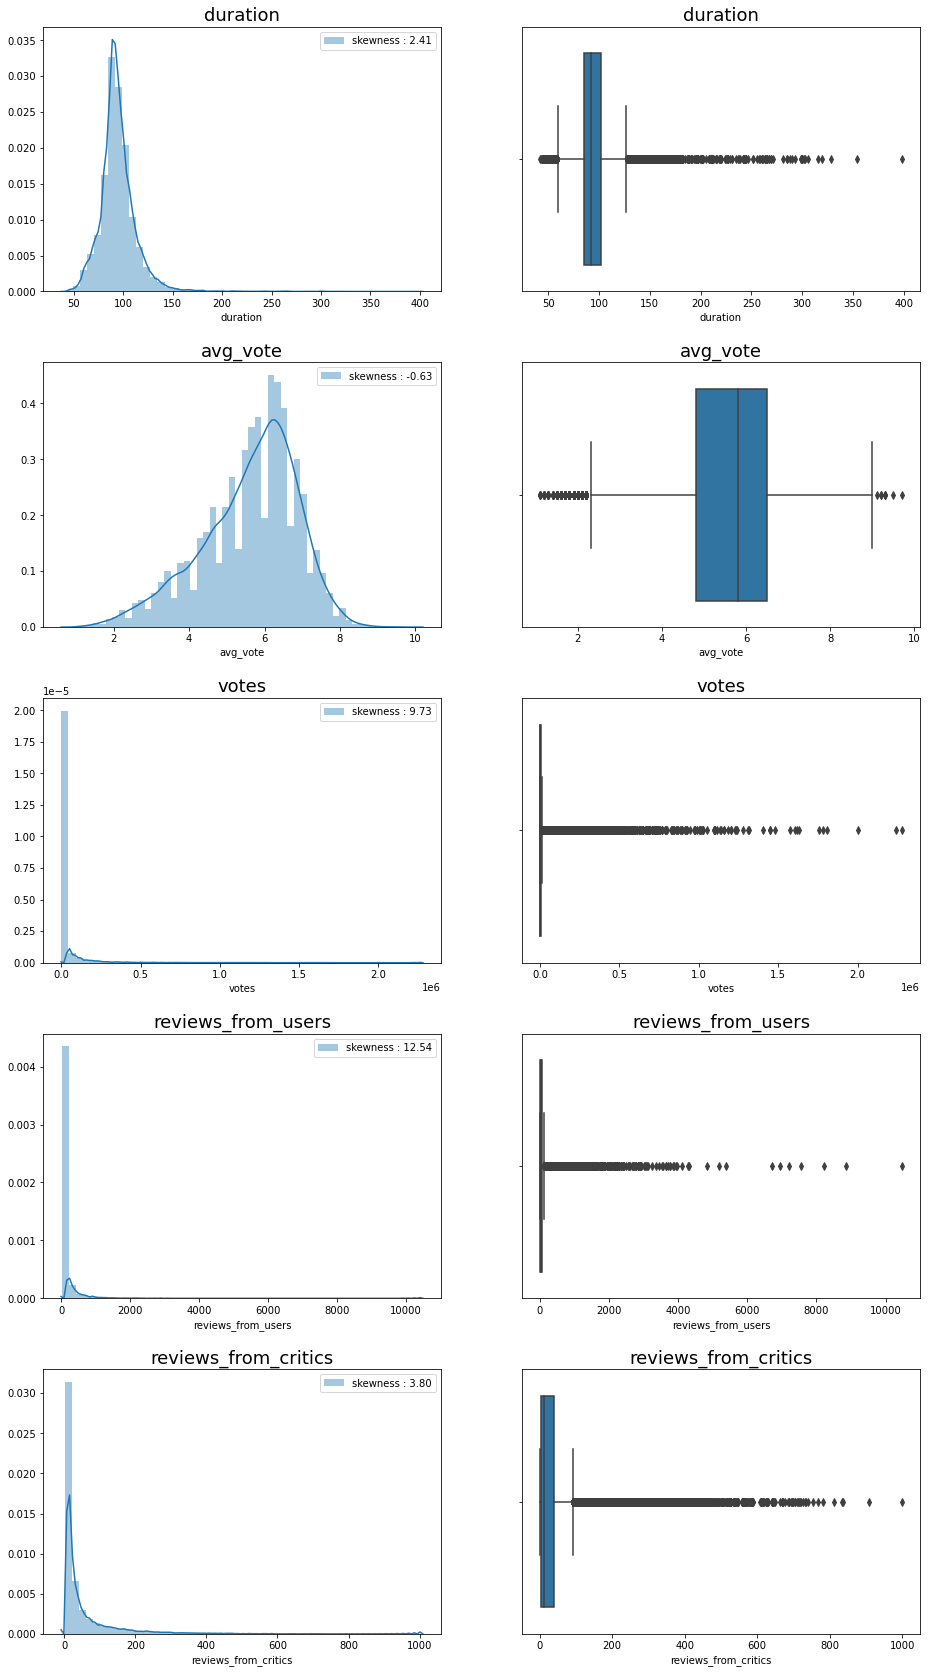

In [93]:
# Grid of Visualizations of numerical features
fig, ax = plt.subplots(5, 2, figsize = (14, 24))
fig.tight_layout(pad = 5)

for i, n in enumerate(num_data):
    sns.distplot(ax = ax[i,0], a = dataset[n].dropna(), label = 'skewness : %.2f'%(dataset[n].skew()))
    ax[i,0].set_title(n, fontsize = 18)
    ax[i,0].legend(loc = 'best')
    
    sns.boxplot(ax = ax[i, 1], x = dataset[n].dropna())
    ax[i, 1].set_title(n, fontsize = 18)
plt.show()

In [94]:
# Here we'll feature engineer - creating a decades feature for each dataset
dataset['year'].replace('TV Movie 2019', 2019, inplace = True)
dataset['year'] = dataset['year'].astype(int)
movies_by_decades = dataset[['title', 'year','avg_vote', 'votes']]
decades = movies_by_decades['year']//10*10
decades = decades.astype(str)+' - '+ (decades+9).astype(str)
decades_column = pd.DataFrame(decades)
movies_by_decades.insert(3, 'decades',decades_column)
movies_by_decades.head()

,title,year,avg_vote,decades,votes
0,Miss Jerry,1894,5.9,1890 - 1899,154
3,Cleopatra,1912,5.2,1910 - 1919,446
5,"From the Manger to the Cross; or, Jesus of Naz...",1912,5.7,1910 - 1919,484
9,Richard III,1912,5.5,1910 - 1919,225
17,Amore di madre,1914,5.8,1910 - 1919,187


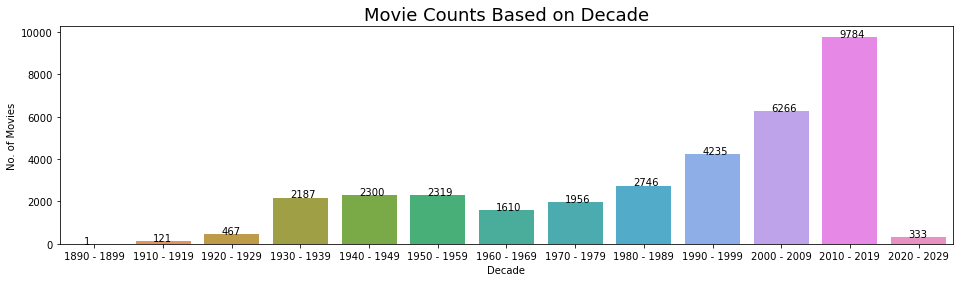

In [95]:
# We'll get movie counts based on decade
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))
decades = movies_by_decades.groupby('decades')['title'].count().index
count = movies_by_decades.groupby('decades')['title'].count()
sns.barplot(ax = ax, x = decades, y = count)
ax.set_title('Movie Counts Based on Decade', fontsize = 18)
ax.set_xlabel('Decade')
for index,count in enumerate(count.astype(int)):
       ax.text(x=index-0.15 , y =count+1 , s=f"{count}" , fontdict=dict(fontsize=10))
ax.set_ylabel('No. of Movies')
plt.show()

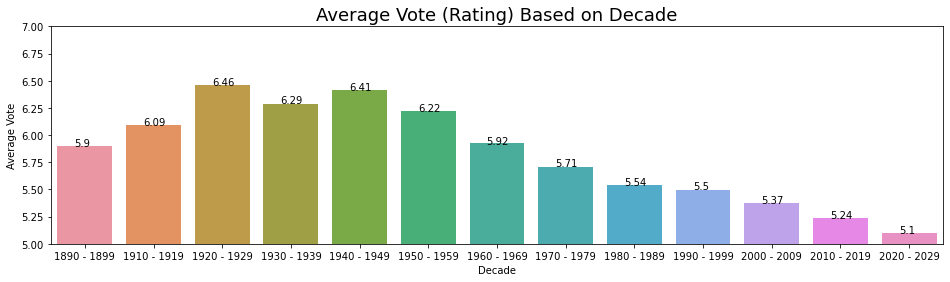

In [96]:
# Average Vote based on decade
max_width = 15
fig, ax = plt.subplots(figsize = (16,4))
decades = movies_by_decades.groupby('decades')['avg_vote'].mean().index
avg_vote = movies_by_decades.groupby('decades')['avg_vote'].mean()
sns.barplot(ax = ax, x = decades, y = avg_vote)
ax.set_title('Average Vote (Rating) Based on Decade', fontsize = 18)
ax.set_xlabel('Decade')
for index,avg_vote in enumerate(np.round(avg_vote, 2)):
       ax.text(x=index-0.15 , y =avg_vote+0 , s=f"{avg_vote}" , fontdict=dict(fontsize=10))
ax.set_ylabel('Average Vote')
ax.set_ylim((5, 7))

plt.show()

In [97]:
# Features that used in this recommender system is 'title' (as index),  'genre', 'director', 'actors', 'description'
data_recsys=dataset[['title', 'genre', 'director', 'actors', 'description']].reset_index(drop = True)
data_recsys.head()


,title,genre,director,actors,description
0,Miss Jerry,Romance,Alexander Black,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.
1,Cleopatra,"Drama, History",Charles L. Gaskill,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...
2,"From the Manger to the Cross; or, Jesus of Naz...","Biography, Drama",Sidney Olcott,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ..."
3,Richard III,Drama,"André Calmettes, James Keane","Robert Gemp, Frederick Warde, Albert Gardner, ...",Richard of Gloucester uses manipulation and mu...
4,Amore di madre,Drama,D.W. Griffith,"Henry B. Walthall, Josephine Crowell, Lillian ...",John Howard Payne at his most miserable point ...


In [98]:
# Preprocess the data

data_recsys['genre'] = data_recsys['genre'].fillna('').astype('str').str.lower()
data_recsys['genre'] = data_recsys['genre'].str.split(',')

data_recsys['director'] = data_recsys['director'].fillna('').astype('str').str.lower()
data_recsys['director'] = data_recsys['director'].str.split(',')

data_recsys['actors'] = data_recsys['actors'].fillna('').astype('str').str.lower()
data_recsys['actors'] = data_recsys['actors'].str.split(',')

data_recsys['description'] = data_recsys['description'].fillna('').astype('str').str.lower()
data_recsys['description'] = data_recsys['description'].str.translate(str.maketrans('', '', string.punctuation))

data_recsys.set_index('title', inplace = True)

# Creating KeyWords Column
listStopwords = set(stopwords.words('english'))
filtered = []
ps = PorterStemmer() 
for i, text in enumerate(data_recsys['description'].str.split()):
    for word in text:
        # Filtering/Removing stopwords in the text
        if word not in listStopwords:
            # Stemming words
            word_stemmed = ps.stem(word)
            filtered.append(word_stemmed)
    data_recsys['description'][i] = filtered
    filtered = []
data_recsys['key_words'] = ''
for i, text in data_recsys.iterrows():
    words = ''
    for col in data_recsys.columns:
        words = words + ' '.join(text[col]) + ' '
    data_recsys['key_words'][i] = words
data_recsys.head()

,genre,director,actors,description,key_words
title,,,,,
Miss Jerry,[romance],[alexander black],"[blanche bayliss, william courtenay, chaunce...","[adventur, femal, report, 1890]",romance alexander black blanche bayliss willi...
Cleopatra,"[drama, history]",[charles l. gaskill],"[helen gardner, pearl sindelar, miss fieldin...","[fabl, queen, egypt, affair, roman, gener, mar...",biography drama history joseph l. mankiewicz...
"From the Manger to the Cross; or, Jesus of Nazareth","[biography, drama]",[sidney olcott],"[r. henderson bland, percy dyer, gene gaunti...","[account, life, jesu, christ, base, book, new,...",biography drama sidney olcott r. henderson bl...
Richard III,[drama],"[andré calmettes, james keane]","[robert gemp, frederick warde, albert gardne...","[richard, gloucest, use, manipul, murder, gain...",drama andré calmettes james keane robert gemp...
Amore di madre,[drama],[d.w. griffith],"[henry b. walthall, josephine crowell, lilli...","[john, howard, payn, miser, point, life, write...",drama d.w. griffith henry b. walthall josephi...


In [99]:
# Convert a collection of text documents to a vector of term/token counts (CountVectorizer)
count = CountVectorizer()
count_matrix = count.fit_transform(data_recsys['key_words']).astype(float)
del decades
del ps
del avg_vote
del count
del movies_by_decades 


In [101]:
# THIS TAKES UP A LOT OF RAM! BE WARY! ~680 chunks will run
# Cosine similarity is a metric used to measure how similar the documents are irrespective of their size
chunk_size = 50 
matrix_len = count_matrix.shape[0] # Not sparse numpy.ndarray
norm_count = count_matrix.astype(np.float16)
print(matrix_len)
# Calculate cosine similarity chunk by chunk
def similarity_cosine_by_chunk(start, end):
    if end > matrix_len:
        end = matrix_len
    return cosine_similarity(X=norm_count[start:end], Y=norm_count, dense_output = False)
cosine_similarity_all = []
i=0
a = 0
for chunk_start in range(0, matrix_len, chunk_size):
    if a % 20 == 0:
        print(a)
    # Initialize first cosine sim chunk (for first concatenating chunks purpose)
    if i == 0: 
        cosine_sim = similarity_cosine_by_chunk(chunk_start, chunk_start+chunk_size)
    
    # Initialize other cosine sim chunk, then concatenating chunk by chunk untill all chunks concatenated
    else :
        cosine_similarity_chunk= similarity_cosine_by_chunk(chunk_start, chunk_start+chunk_size)
        # Use type data float32 for reduce memory usage
        cosine_sim = sparse.vstack((cosine_sim.astype(np.float16), cosine_similarity_chunk.astype(np.float16)))
    
    # Change value i != 0 for execute else statemenx, because we dont need execute if statement anymore (if statement only to initialize first chunk for first concatenating purpose)
    i= 1
    a = a + 1

34325
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680


In [159]:
# Create function that return 5 recommended/similar movies based on input

# Create variable index
index_movies = pd.Series(data_recsys.index)

# Movies Recommendation function
def recommendation_movies(title, cosine_sim = cosine_sim):
    recommended_movies = []
    index_movie_input = index_movies[index_movies == title].index[0]
    score_movies = pd.Series(np.squeeze(np.asarray(cosine_sim.astype('float32').todense()[index_movie_input]))).sort_values(ascending = False)
    top_5_index_movies = list(score_movies.iloc[1:6].index)
    # Get movies title and year by index (top 10 movies)
    for i in top_5_index_movies:
        recommended_movies.append(dataset['title'].iloc[i] + ' (' + str(dataset['year'].iloc[i]) + ')')
    return recommended_movies

In [160]:
recommendation_movies('Madagascar')

['Madagascar 3 - Ricercati in Europa (2012)',
 'Madagascar 2 (2008)',
 'I pinguini di Madagascar (2014)',
 'Megamind (2010)',
 'Baby boss (2017)']

In [166]:
 recommendation_movies('Thor: The Dark World')

['Thor (2011)',
 'Thor: Ragnarok (2017)',
 'Avengers: Infinity War (2018)',
 'Avengers: Endgame (2019)',
 'The Avengers (2012)']